In [3]:
!pip install scikit-learn -q
!pip install pandas -q
!pip install numpy -q
!pip install matplotlib -q
!pip install seaborn -q

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from sklearn import preprocessing, model_selection
import random
import seaborn as sns

C:\Users\goert\AppData\Local\Temp\ipykernel_8808\3755218005.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
DATA_PATH = 'D:/Master of Applied IT/data/processed/WESAD'
QUALITY_THRESHOLD = 128
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2

In [6]:
dataset = pd.read_csv(DATA_PATH + "/merged_data.csv")

In [7]:
dataset.dtypes

id           object
X           float64
Y           float64
datetime    float64
Z           float64
EDA         float64
TEMP        float64
HR          float64
dtype: object

In [8]:
dataset


,id,X,Y,datetime,Z,EDA,TEMP,HR
0,S2,29.0,-6.0,1.495437e+09,55.0,0.000000,382.18,101.00
1,S2,29.0,-6.0,1.495437e+09,56.0,0.328021,382.18,101.00
2,S2,28.0,-6.0,1.495437e+09,56.0,0.410026,382.18,101.00
3,S2,29.0,-6.0,1.495437e+09,56.0,0.433090,382.18,101.00
4,S2,28.0,-6.0,1.495437e+09,55.0,0.444622,35.05,101.00
...,...,...,...,...,...,...,...,...
427785,S17,-7.0,12.0,1.502443e+09,58.0,1.542317,31.57,74.03
427786,S17,-3.0,13.0,1.502443e+09,64.0,1.562787,31.57,74.03
427787,S17,-2.0,13.0,1.502443e+09,60.0,1.700963,31.57,73.65
427788,S17,-1.0,13.0,1.502443e+09,62.0,1.748301,31.57,73.65


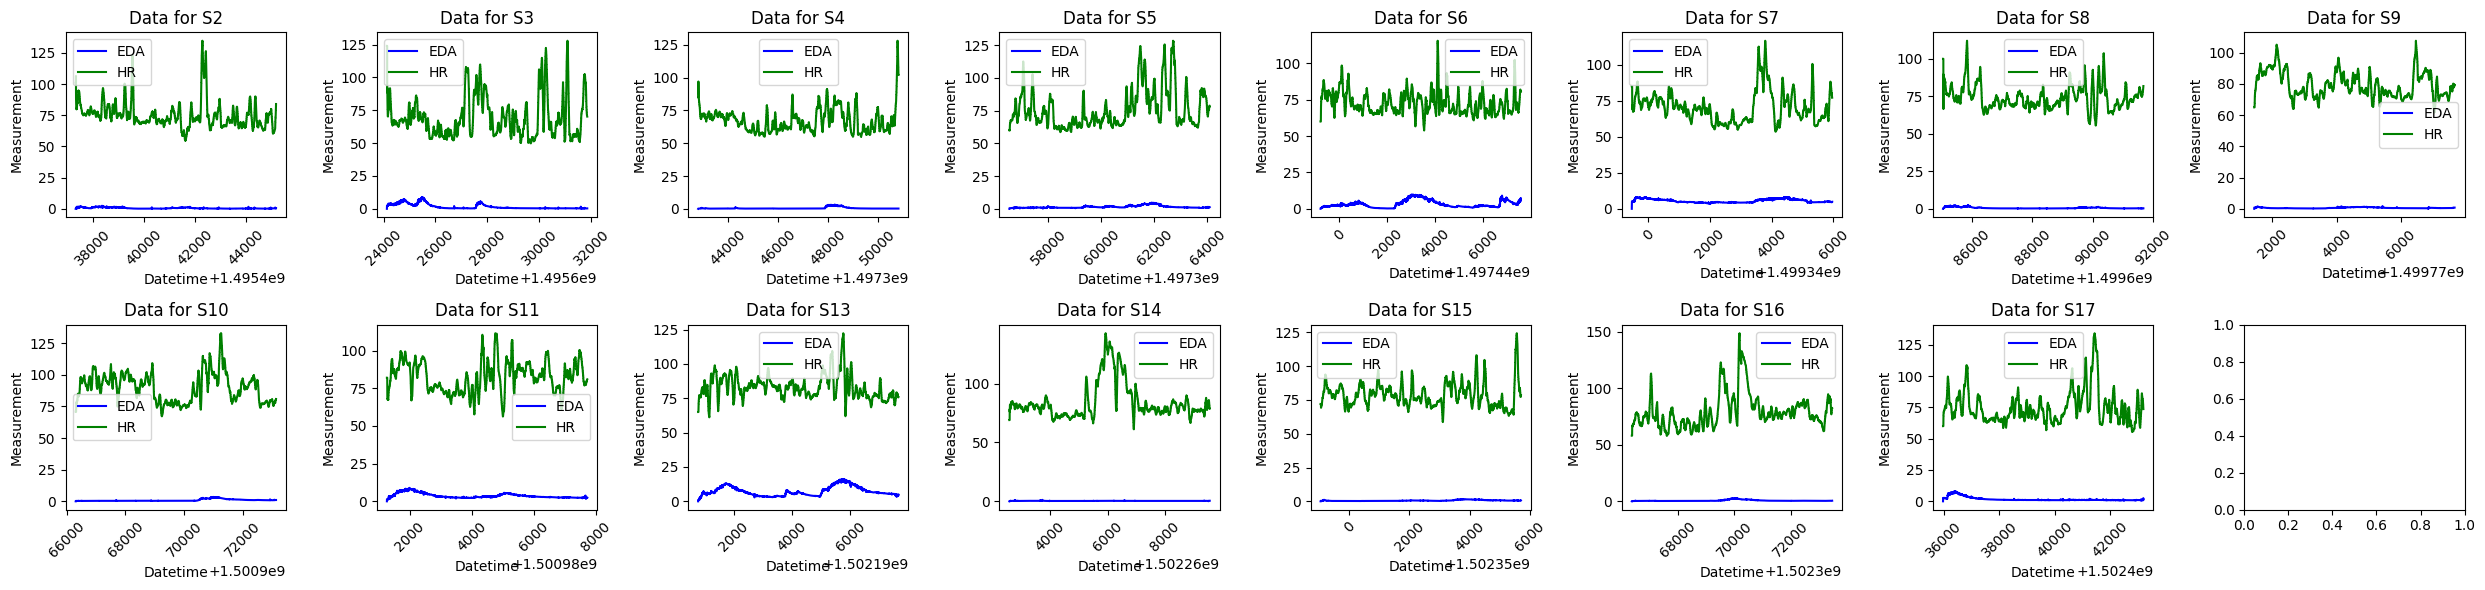

In [10]:
# Create subplots
fig, axes = plt.subplots(2, 8, figsize=(25, 6))  # Increased figure size
axes = axes.flatten()

# Define unique_ids
unique_ids = dataset['id'].unique()

# Iterate through each unique id
for i, ax in enumerate(axes):
    if i < len(unique_ids):
        # Filter data for each id
        subset_data = dataset[dataset['id'] == unique_ids[i]]
        
        # Plotting
        sns.lineplot(x='datetime', y='EDA', data=subset_data, ax=ax, color='blue', label='EDA')
        # sns.lineplot(x='datetime', y='TEMP', data=subset_data, ax=ax, color='orange', label='TEMP')
        sns.lineplot(x='datetime', y='HR', data=subset_data, ax=ax, color='green', label='HR')
        sns.lineplot(x='datetime', y='HR', data=subset_data, ax=ax, color='yellow', label='HR')

        ax.set_title(f"Data for {unique_ids[i]}")
        ax.set_xlabel('Datetime')
        ax.set_ylabel('Measurement')
        ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

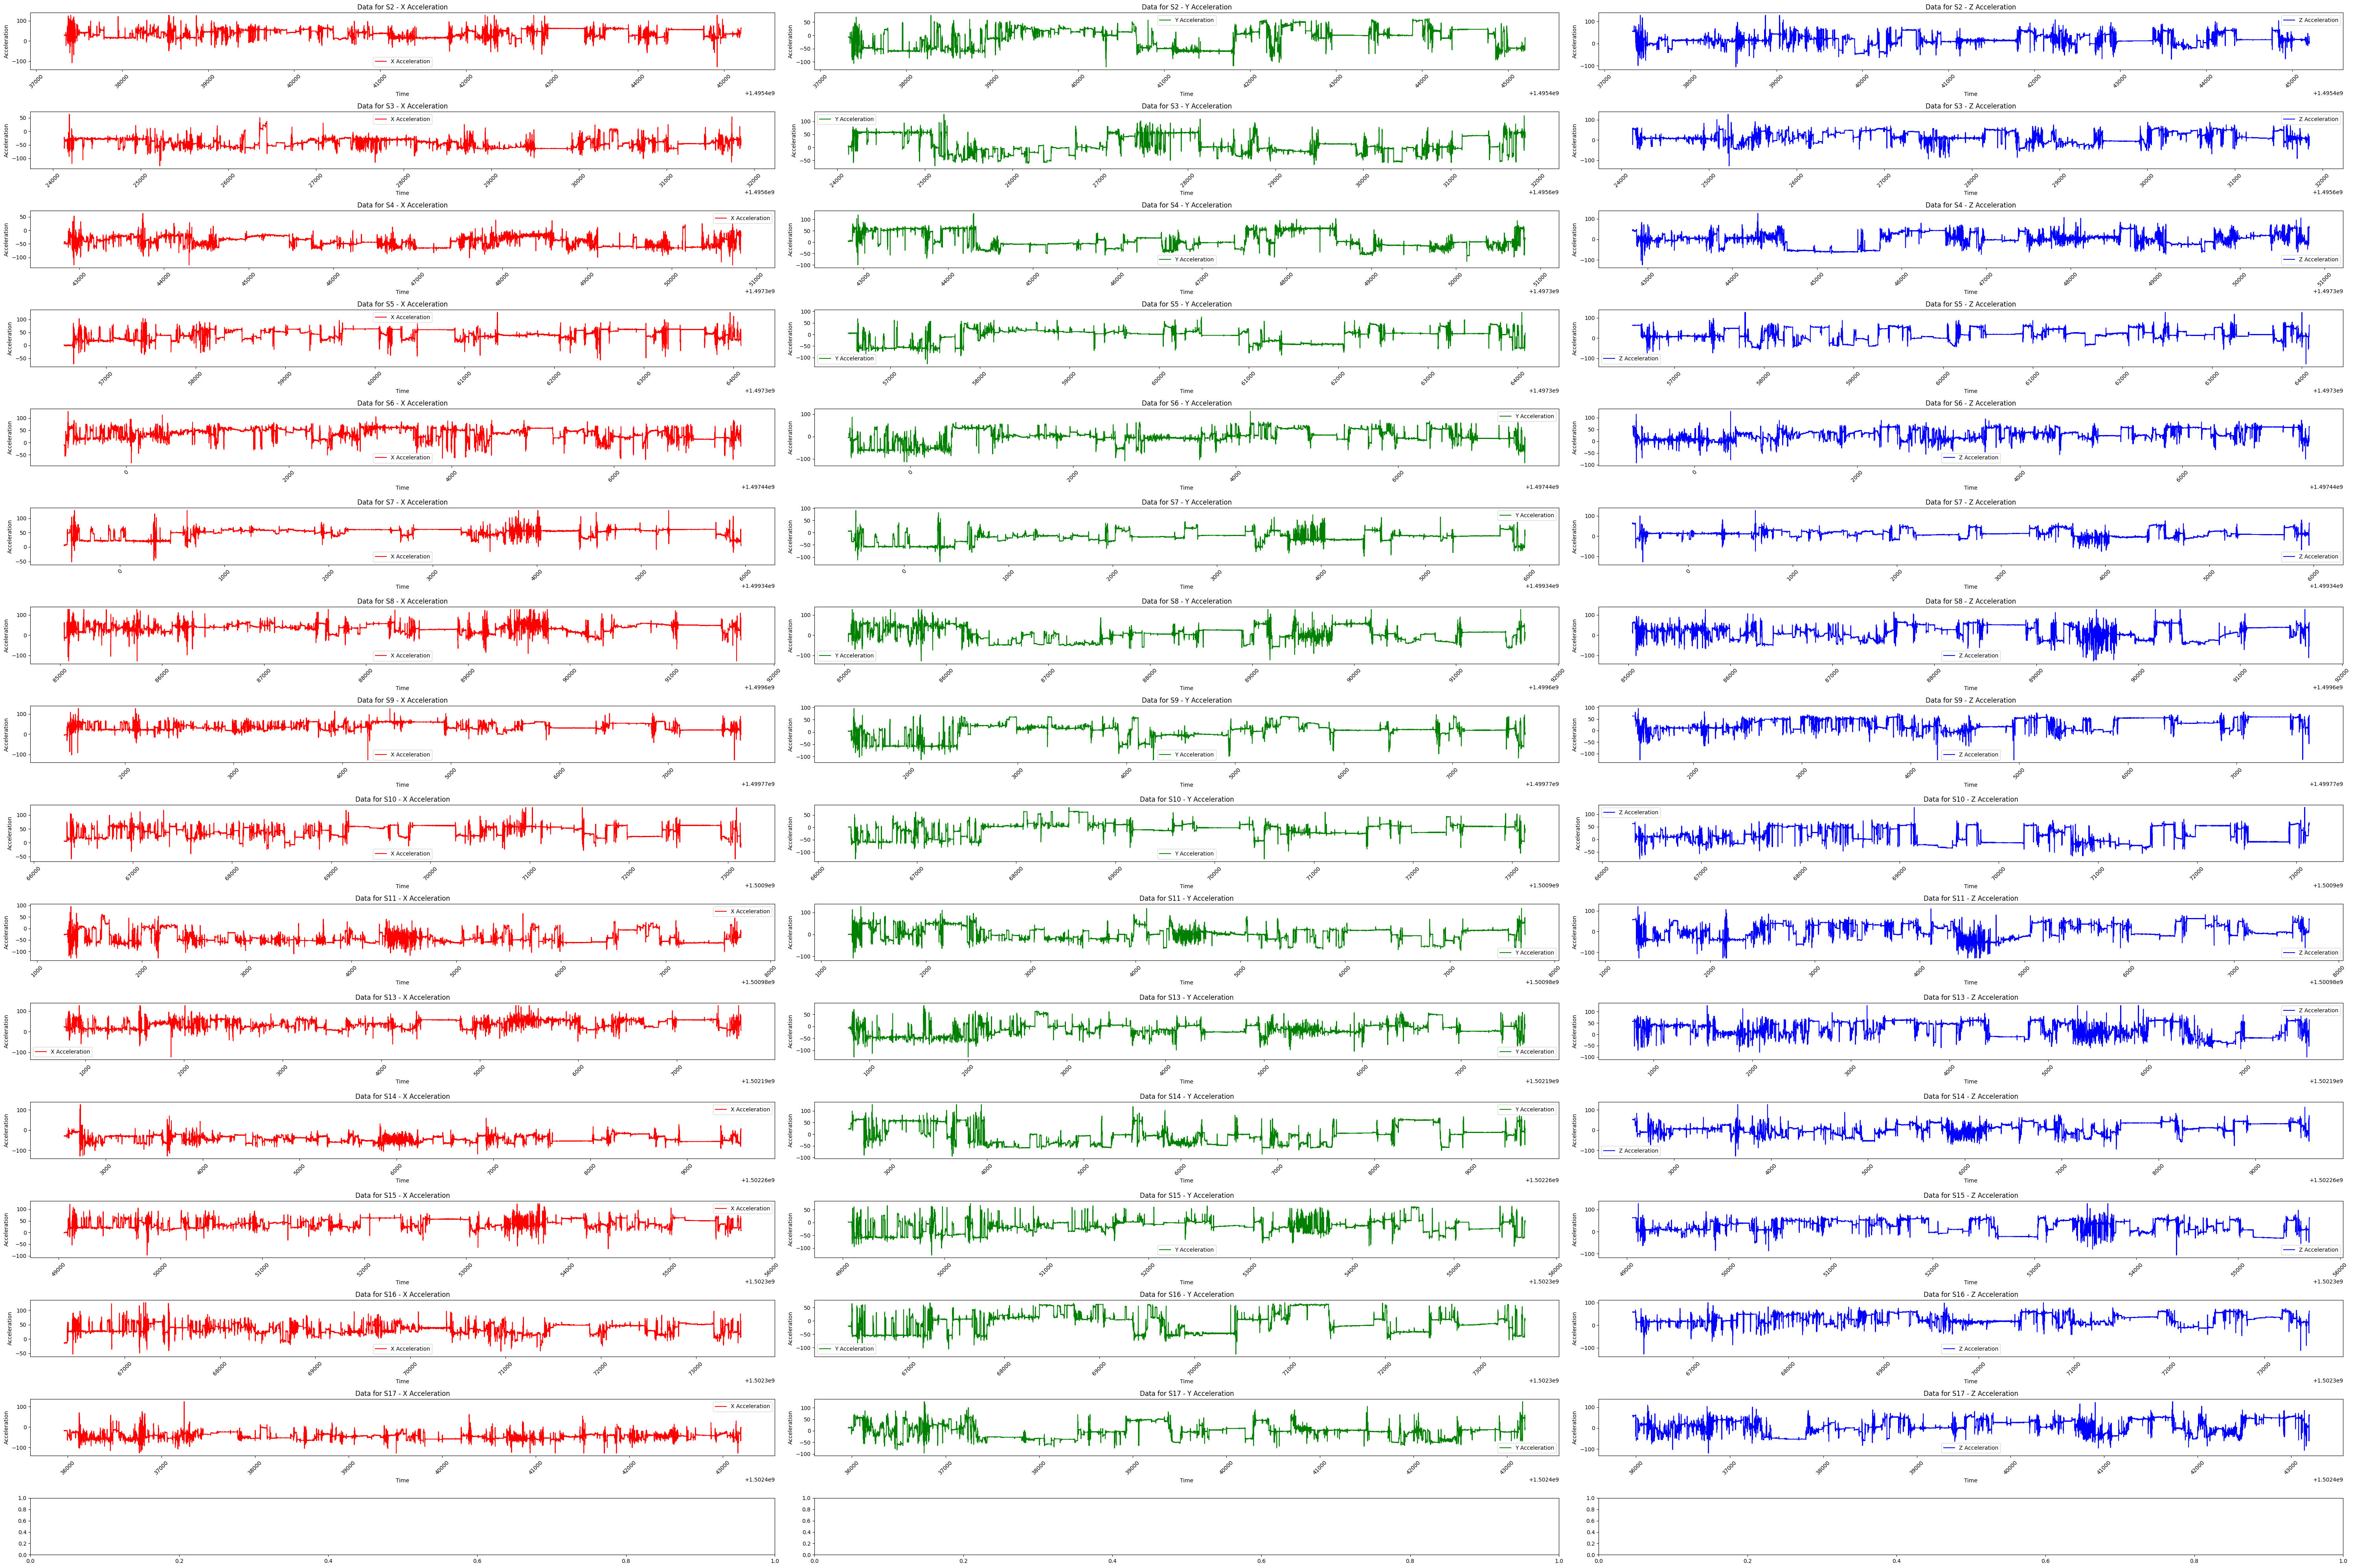

In [29]:
# Create subplots
fig, axes = plt.subplots(16, 3, figsize=(60, 40))  # Increased figure size

# Define colors for each acceleration component
colors = ['red', 'green', 'blue']

# Iterate through each unique id
for i, unique_id in enumerate(unique_ids):
    # Filter data for each id
    subset_data = dataset[dataset['id'] == unique_id]
    
    # Iterate through X, Y, and Z accelerations
    for j, accel_component in enumerate(['X', 'Y', 'Z']):
        ax = axes[i, j]  # Select the appropriate subplot
        
        # Plot acceleration component with different color
        ax.plot(subset_data['datetime'], subset_data[accel_component], label=f'{accel_component} Acceleration', color=colors[j])
        ax.set_title(f"Data for {unique_id} - {accel_component} Acceleration")
        ax.set_xlabel('Time')
        ax.set_ylabel('Acceleration')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()